In [1]:
# Defining the Dataset Path and extracting it to dataset folder

import zipfile
import shutil

dataset_path = '/content/V2 - Traffic Signs.zip'
with zipfile.ZipFile(dataset_path, 'r') as zip_file:
     zip_file.extractall('/content/dataset')

In [2]:
!pip install efficientnet_pytorch
!pip install torchmetrics
!pip install torchinfo
import torch
from torchvision import datasets
from torchsummary import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import flatten
import torch.optim as optim
import os
import torchvision.transforms as transforms
import seaborn as sns
import torch.optim as optim
from torchmetrics import Accuracy
import time
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import cv2

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
# Labels are in YOLOv8 annotation format. Read the annotations - Crop the image - Save it

def crop_and_save_images(images_folder, labels_folder, op_folder):

    for image_file in os.listdir(images_folder):

        if image_file.endswith('.jpg'):
            image_path = os.path.join(images_folder, image_file)
            image = cv2.imread(image_path)
            if image is None:
                continue

            annotation_file_path = os.path.join(labels_folder, os.path.splitext(image_file)[0] + '.txt')
            if not os.path.exists(annotation_file_path):
                print(f"Annotation file does not exist for: {image_file}")
                continue

            with open(annotation_file_path, 'r') as file:
                 lines = file.readlines()

            annotations = [l.strip().split() for l in lines]

            for values in annotations:
                class_label = int(values[0])
                x, y, w, h = map(float,values[1:])
                x1 = int((x - w / 2) * image.shape[1])
                y1 = int((y - h / 2) * image.shape[0])
                x2 = int((x + w / 2) * image.shape[1])
                y2 = int((y + h / 2) * image.shape[0])

                roi = image[y1:y2,x1:x2]
                if roi.size == 0:
                    continue

                output_path = os.path.join(op_folder,str(class_label))
                os.makedirs(output_path, exist_ok=True)
                op_file = os.path.join(output_path, f'{os.path.splitext(image_file)[0]}_{class_label}.jpg')
                cv2.imwrite(op_file, roi)

train_images_folder = '/content/dataset/V2 - Traffic Signs/train/images'
train_labels_folder = '/content/dataset/V2 - Traffic Signs/train/labels'
train_op_folder = '/content/cropped_images/train'

val_images_folder = '/content/dataset/V2 - Traffic Signs/valid/images'
val_labels_folder = '/content/dataset/V2 - Traffic Signs/valid/labels'
val_op_folder = '/content/cropped_images/val'

crop_and_save_images(train_images_folder, train_labels_folder, train_op_folder)
crop_and_save_images(val_images_folder, val_labels_folder, val_op_folder)


In [4]:
# Combine train and val folders in the dataset

import shutil

def combine_folders(train_folder, val_folder, op_folder):

    os.makedirs(op_folder, exist_ok=True)

    train_class_names = os.listdir(train_folder)
    train_class_names = sorted(train_class_names)
    val_class_names = os.listdir(val_folder)
    val_class_names = sorted(val_class_names)

    for class_name in train_class_names:

        if not os.path.exists(os.path.join(op_folder,class_name)):
            os.makedirs(os.path.join(op_folder,class_name))

        train_temp = os.path.join(train_folder,class_name)
        for filename in os.listdir(train_temp):
            shutil.copy(os.path.join(train_temp,filename), os.path.join(op_folder,class_name))

        val_temp = os.path.join(val_folder,class_name)
        for filename in os.listdir(val_temp):
            shutil.copy(os.path.join(val_temp,filename), os.path.join(op_folder,class_name))

    for class_name in val_class_names:

        if not os.path.exists(os.path.join(op_folder,class_name)):
            os.makedirs(os.path.join(op_folder,class_name))

        train_temp = os.path.join(train_folder,class_name)
        for filename in os.listdir(train_temp):
            shutil.copy(os.path.join(train_temp,filename), os.path.join(op_folder,class_name))

        val_temp = os.path.join(val_folder,class_name)
        for filename in os.listdir(val_temp):
            shutil.copy(os.path.join(val_temp,filename), os.path.join(op_folder,class_name))


train_folder = "/content/cropped_images/train"
val_folder = "/content/cropped_images/val"
op_folder = "/content/combined_data"

combine_folders(train_folder, val_folder, op_folder)

In [5]:
os.makedirs("/content/combined_data_new", exist_ok=True)

for i in range(55):
    if not os.path.exists(os.path.join("/content/combined_data_new",f"{i:02d}")):
        os.makedirs(os.path.join("/content/combined_data_new",f"{i:02d}"))

src_dir = "/content/combined_data"
op_dir = "/content/combined_data_new"

for dir in os.listdir(src_dir):
    if os.path.isdir(os.path.join(src_dir,dir)):
        if int(dir) < 10 :
            new_dir = f"{int(dir):02d}"
        else:
            new_dir = dir

        if not os.path.exists(os.path.join(op_dir, new_dir)):
              os.makedirs(os.path.join(op_dir, new_dir))

        for filename in os.listdir(os.path.join(src_dir,dir)):
            shutil.move(os.path.join(src_dir,dir,filename), os.path.join(op_dir,new_dir))


In [6]:
# # This image was wrongly mapped in the original dataset. Hence removing this file

# os.remove("/content/combined_data_new/42/AUTO_COLLECTED_PICTURE_66_png.rf.20792a03a22b3cb48ff426cd19bca4c6_42.jpg")

In [7]:
transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root='combined_data_new',transform=transform)

class_names = dataset.classes
unique_folders = set()

for image_path, label in dataset.samples:
    folder_name = class_names[label]
    unique_folders.add((folder_name, label))

for folder_name, label in unique_folders:
    print(f"Folder Name: {folder_name}, Label: {label}")

from torch.utils.data import random_split

dataset_len = [int(len(dataset) * 0.7), int(len(dataset) * 0.15)]
dataset_len.append(int(len(dataset) - sum(dataset_len)))
train_dataset, val_dataset, test_dataset = random_split(dataset, dataset_len)

Folder Name: 47, Label: 47
Folder Name: 18, Label: 18
Folder Name: 35, Label: 35
Folder Name: 46, Label: 46
Folder Name: 05, Label: 5
Folder Name: 22, Label: 22
Folder Name: 26, Label: 26
Folder Name: 03, Label: 3
Folder Name: 31, Label: 31
Folder Name: 50, Label: 50
Folder Name: 04, Label: 4
Folder Name: 02, Label: 2
Folder Name: 21, Label: 21
Folder Name: 27, Label: 27
Folder Name: 32, Label: 32
Folder Name: 00, Label: 0
Folder Name: 19, Label: 19
Folder Name: 09, Label: 9
Folder Name: 28, Label: 28
Folder Name: 23, Label: 23
Folder Name: 43, Label: 43
Folder Name: 54, Label: 54
Folder Name: 24, Label: 24
Folder Name: 08, Label: 8
Folder Name: 37, Label: 37
Folder Name: 39, Label: 39
Folder Name: 33, Label: 33
Folder Name: 40, Label: 40
Folder Name: 38, Label: 38
Folder Name: 01, Label: 1
Folder Name: 49, Label: 49
Folder Name: 51, Label: 51
Folder Name: 34, Label: 34
Folder Name: 12, Label: 12
Folder Name: 13, Label: 13
Folder Name: 30, Label: 30
Folder Name: 48, Label: 48
Folder Na

In [8]:
#Dataset Analysis

print("Total Number of images:",len(dataset))
print("Classes in the dataset:", dataset.classes)

Total Number of images: 7650
Classes in the dataset: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


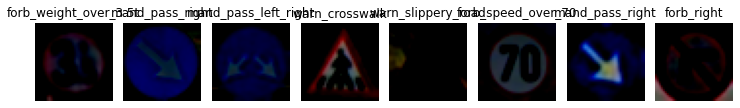

In [9]:
#Visualize the dataset

data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
images,labels = next(iter(data_loader))

labels_map = {0: 'forb_ahead', 1: 'forb_left', 2: 'forb_overtake', 3: 'forb_right', 4: 'forb_speed_over_10', 5: 'forb_speed_over_100',
 6: 'forb_speed_over_130', 7: 'forb_speed_over_20', 8: 'forb_speed_over_30', 9: 'forb_speed_over_40', 10: 'forb_speed_over_5',
 11: 'forb_speed_over_50', 12: 'forb_speed_over_60', 13: 'forb_speed_over_70', 14: 'forb_speed_over_80', 15: 'forb_speed_over_90',
 16: 'forb_stopping', 17: 'forb_trucks', 18: 'forb_u_turn', 19: 'forb_weight_over_3.5t', 20: 'forb_weight_over_7.5t',
 21: 'info_bus_station', 22: 'info_crosswalk', 23: 'info_highway', 24: 'info_one_way_traffic', 25: 'info_parking',
 26: 'info_taxi_parking', 27: 'mand_bike_lane', 28: 'mand_left', 29: 'mand_left_right', 30: 'mand_pass_left',
 31: 'mand_pass_left_right', 32: 'mand_pass_right', 33: 'mand_right', 34: 'mand_roundabout', 35: 'mand_straigh_left',
 36: 'mand_straight', 37: 'mand_straight_right', 38: 'prio_give_way', 39: 'prio_priority_road', 40: 'prio_stop',
 41: 'warn_children', 42: 'warn_construction', 43: 'warn_crosswalk', 44: 'warn_cyclists', 45: 'warn_domestic_animals',
 46: 'warn_other_dangers', 47: 'warn_poor_road_surface', 48: 'warn_roundabout', 49: 'warn_slippery_road', 50: 'warn_speed_bumper',
 51: 'warn_traffic_light', 52: 'warn_tram', 53: 'warn_two_way_traffic', 54: 'warn_wild_animals'}


fig,ax = plt.subplots(1,8,figsize=(10,3))
for i,img in enumerate(images):
    img_np = img.permute(1,2,0).numpy()
    index = labels[i].item()
    ax[i].imshow(img_np.squeeze(), cmap="gray")
    ax[i].set_title(labels_map[index])
    ax[i].axis("off")
plt.tight_layout()
plt.show()

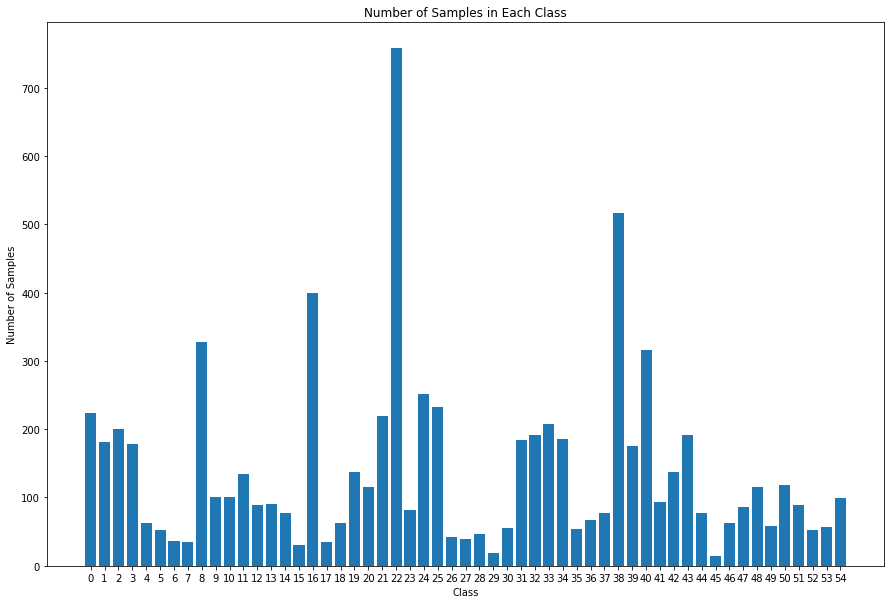

In [10]:
class_counts = {}
for _, label in dataset:
    if label not in class_counts:
        class_counts[label] = 0
    class_counts[label] += 1

labels = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(15, 10))
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class')
plt.xticks(np.arange(len(labels)), labels)
plt.show()

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
#Dataset Analysis

print("Total Number of images in Training Data:",len(train_dataset))
print("Total Number of images in Validation Data:",len(val_dataset))
print("Total Number of images in Testing Data:",len(test_dataset))

Total Number of images in Training Data: 5355
Total Number of images in Validation Data: 1147
Total Number of images in Testing Data: 1148


# **Vision Transformer X Resnet34 Concatenator Model**

In [13]:
# Resnet 34 model which returns the embedding dimension
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=169):
        super(ResNet34, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block2 = self._make_layer(64, 64, 3)
        self.block3 = self._make_layer(64, 128, 4, stride=2)
        self.block4 = self._make_layer(128, 256, 6, stride=2)
        self.block5 = self._make_layer(256, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
resnet_model_con = ResNet34().to(device)

# Vision Transformer Model - This model returns the embedding dimension

class VisionTransformer_Model(nn.Module):
    def __init__(self, in_channels, img_size,embedding_dim, num_attention_heads, patch_size, num_layers):
        super(VisionTransformer_Model, self).__init__()

        self.patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, embedding_dim , kernel_size=patch_size, stride=patch_size),
            nn.BatchNorm2d(embedding_dim),
            nn.Flatten(2)
        )

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_attention_heads), num_layers = num_layers
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        return x

in_channels = 3
img_size = 40
embedding_dim_vision = 13 * 13
num_attention_heads = 13
patch_size = 3
num_layers = 12

vit_model_con = VisionTransformer_Model(in_channels, img_size,embedding_dim_vision, num_attention_heads, patch_size, num_layers).to(device)


In [14]:
# Concatenated Vision Transformer and Resnet Model

class VisionTransformer_ResNet_Concatenator(nn.Module):
    def __init__(self, vision_model, resnet_model, conv1d_out_channels, num_classes):
        super(VisionTransformer_ResNet_Concatenator, self).__init__()
        self.vision_model = vision_model
        self.resnet_model = resnet_model
        self.conv1d_out_channels = conv1d_out_channels
        with torch.no_grad():
            resnet_output_dim = resnet_model(torch.zeros(1, 3, 40, 40).to(device)).shape[1]
            vit_output_dim = vision_model(torch.zeros(1, 3, 40, 40).to(device)).shape[1]
        self.concat_dim = vit_output_dim + resnet_output_dim
        self.conv1d = nn.Conv1d(self.concat_dim, conv1d_out_channels, kernel_size=1)
        self.fc = nn.Linear(conv1d_out_channels, num_classes)

    def forward(self, x):
        vit_output = self.vision_model(x)
        resnet_output = self.resnet_model(x)
        concatenated_output = torch.cat((vit_output, resnet_output), dim=1)
        concatenated_output = concatenated_output.unsqueeze(2)
        concatenated_output = concatenated_output.permute(0, 1, 2)
        conv1d_output = self.conv1d(concatenated_output)
        conv1d_output = conv1d_output.squeeze(2)
        output = self.fc(conv1d_output)
        return output

conv1d_out_channels = 128

In [23]:
vit_resnet_model = VisionTransformer_ResNet_Concatenator(vit_model_con, resnet_model_con, conv1d_out_channels, num_classes).to(device)
print(vit_resnet_model)

VisionTransformer_ResNet_Concatenator(
  (vision_model): VisionTransformer_Model(
    (patch_embedding): Sequential(
      (0): Conv2d(3, 169, kernel_size=(3, 3), stride=(3, 3))
      (1): BatchNorm2d(169, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Flatten(start_dim=2, end_dim=-1)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=169, out_features=169, bias=True)
          )
          (linear1): Linear(in_features=169, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=169, bias=True)
          (norm1): LayerNorm((169,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((169,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): D

In [15]:
def train_model(model, epochs_no, train_loader, test_loader, val_loader, optimizer, criterion, device):

    for epoch in range(epochs_no):

        train_pred = []
        vald_pred = []
        total_length = 0

        total_training_loss = 0.0
        model.train()
        for data in train_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            optimizer.zero_grad()
            model.to(device)
            outputs = model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred, target).item())
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss /= total_length

        total_length = 0

        model.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs, target = data
                inputs, target = inputs.to(device), target.to(device)
                model.to(device)
                outputs = model(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred, target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss /= total_length

        training_acc_data.append(sum(train_pred) / len(train_pred))
        val_acc_data.append(sum(vald_pred) / len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch+1}, Loss: {total_training_loss}, val_loss: {total_validation_loss}, train_acc: {training_acc_data[-1]}, val_acc : {val_acc_data[-1]}')

    return training_loss_data, val_loss_data, training_acc_data, val_acc_data

In [16]:
accuracy = Accuracy(task = "multiclass", num_classes=55).to(device)

training_loss_data = []
val_loss_data = []
training_acc_data = []
val_acc_data = []

num_classes = 55

vit_resnet_model = VisionTransformer_ResNet_Concatenator(vit_model_con, resnet_model_con, conv1d_out_channels, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_resnet_model.parameters(),lr=1e-4, weight_decay = 1e-5)
epoch_no = 20

training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(vit_resnet_model,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion,device)

Epoch: 1, Loss: 0.06549430524601656, val_loss: 0.035056832154730454, train_acc: 0.49556953459978104, val_acc : 0.6844778805971146
Epoch: 2, Loss: 0.025872220339672684, val_loss: 0.02311656292147915, train_acc: 0.7673160174772853, val_acc : 0.7927597744597329
Epoch: 3, Loss: 0.015305008591056204, val_loss: 0.016219375802832472, train_acc: 0.8634672619047619, val_acc : 0.859278549750646
Epoch: 4, Loss: 0.010191378782109387, val_loss: 0.016669072684975635, train_acc: 0.9112723214285714, val_acc : 0.8606288582086563
Epoch: 5, Loss: 0.007180230596374953, val_loss: 0.011445968927459917, train_acc: 0.9393601190476191, val_acc : 0.914126800166236
Epoch: 6, Loss: 0.004765773030566652, val_loss: 0.013384978549186313, train_acc: 0.9613095238095238, val_acc : 0.9050604419575797
Epoch: 7, Loss: 0.003824706028461679, val_loss: 0.014604178504935533, train_acc: 0.9687669103344282, val_acc : 0.8908500522375107
Epoch: 8, Loss: 0.003378484430475061, val_loss: 0.01420135857129783, train_acc: 0.97302827380

In [17]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []
testing_pred = []
Y_test = []
predictions = []

total_testing_loss = 0
total_length = 0
vit_resnet_model.to(device)
vit_resnet_model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        outputs = vit_resnet_model(inputs)
        Prob = nn.Softmax(dim=1)(outputs)
        Y_pred = Prob.argmax(1).int()

        test_loss = criterion(outputs, target)
        total_testing_loss += test_loss.item()
        batch_length = target.size(0)
        total_length += batch_length

        acc = accuracy(Y_pred, target).item()
        testing_pred.append(acc)
        Y_test.append(target)
        predictions.append(Y_pred)

    average_testing_loss = total_testing_loss / total_length
    testing_loss_data.append(average_testing_loss)
    testing_acc_data.append(sum(testing_pred) / len(testing_pred))

Y_pred = torch.cat([p for p in predictions])
Y_test = torch.cat([t for t in Y_test])
Final_accuracy = accuracy(Y_pred, Y_test).item()
precision, recall, f1, support = precision_recall_fscore_support(Y_test.cpu(), Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy * 100:.2f} %")
print(f"Precision     : {precision}")
print(f"Recall        : {recall}")
print(f"F1 Score      : {f1}")

Performance Metrics:
Time to Train : 5.317040205001831 seconds
Accuracy      : 92.25 %
Precision     : [0.9375     1.         1.         0.94736842 0.91666667 1.
 0.75       1.         0.92424242 0.85714286 0.90909091 0.89285714
 0.93333333 0.84210526 0.66666667 1.         0.97916667 0.75
 1.         0.9        0.9        0.97435897 0.94845361 0.875
 0.97222222 0.97368421 1.         0.75       0.42857143 0.77777778
 1.         0.96428571 1.         1.         1.         0.5
 0.90909091 0.94366197 0.96428571 0.94871795 1.         1.
 0.75675676 0.54545455 0.5        0.9        0.94117647 0.9
 0.54545455 1.         1.         1.         1.         0.81818182]
Recall        : [1.         0.92857143 0.97222222 0.94736842 0.57894737 1.
 1.         0.4        0.96825397 1.         1.         0.92592593
 1.         0.94117647 0.4        0.85714286 0.95918367 1.
 0.91666667 0.94736842 0.94736842 0.97435897 0.91089109 1.
 1.         0.94871795 0.9        0.75       1.         0.875
 1.         

In [18]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {training_acc_data[-1]*100:.2f} %")
print(f"Validation Accuracy : {val_acc_data[-1]*100:.2f} %")
print(f"Testing Accuracy : {testing_acc_data[-1]*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 98.25 %
Validation Accuracy : 92.78 %
Testing Accuracy : 92.26 %

Training Loss : 0.00802094470150421
Validation Loss : 0.014597275203240851
Testing Loss : 0.011283281189470652


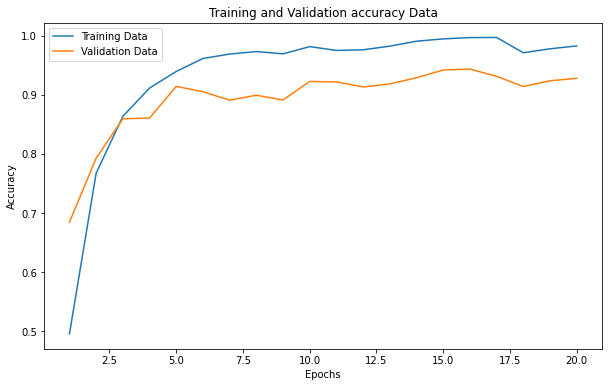

In [19]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy Data')
plt.legend()
plt.show()

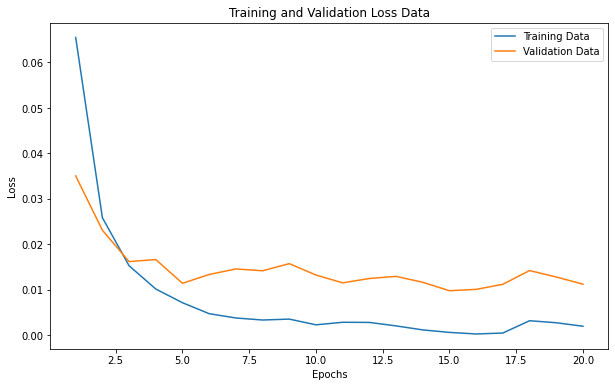

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Data')
plt.legend()
plt.show()

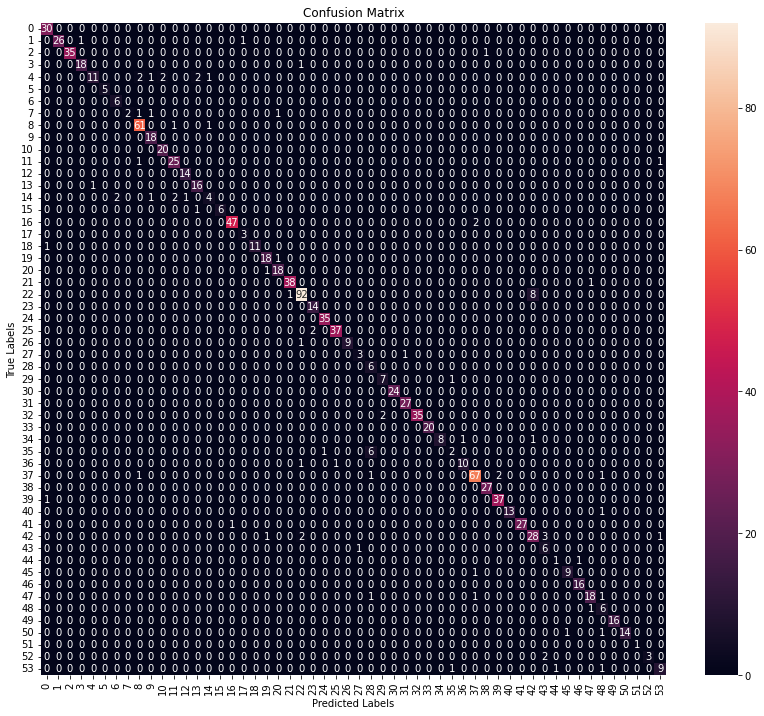

In [21]:
cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(14, 12))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
torch.save(vit_resnet_model.state_dict(), "vit_resnet_model.pth")